### 一、Embedding Module  


#### 1. 什么是Embedding ？  
可以将其想象成一个巨大的密码本  
- 输入：一个单词的编号（例如苹果在词表中的编号为1024）  
- 查询：查找1024页
- 输出：这一页写着长长的向量,比如[0.12,-0.55...]    

因此他的任务是给词表力的每一个Token ID，分配一个长度为D（d_model）的浮点数向量  
输入：[B,S]  
输出：[B,S,D]  
为什么这样做：在ID空间里，10和11孤立；向量空间，可以让模型通过训练，让向量在集合距离上更加接近，赋予了模型处理语义相似性的能力


#### 2.详细工作流程  
1）查找表：Embedding本质是一个形状为（v,d）的矩阵，v为字典大小，d为嵌入维度，将输入的id映射到对应的嵌入向量  
2）稠密表达：相对于传统的one-hot，Embedding能用更小的维度，表达极其丰富的语义  
3）语义抓取：在向量空间中，语义相似的词，向量之间的距离会更短。这种高维向量表征词义的方法，解决了词元不连续的问题  
4）初始化与学习：训练开始时，密码本熵的数字随机生成（Xavier），随着模型的训练，模型会不断调整，直到能够捕捉词与词之间的复杂关系

In [11]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt 
#中文显示
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns 

In [12]:
#初始化embedding 
embedding=nn.Embedding(num_embeddings=5,embedding_dim=3)
print(embedding)

Embedding(5, 3)


In [13]:
#查看初始嵌入查找表（权重）
embedding_table=embedding.weight.data
print("初始嵌入查找表（权重）:\n",{embedding_table.shape})
print(embedding_table)

初始嵌入查找表（权重）:
 {torch.Size([5, 3])}
tensor([[ 0.6231, -0.8228,  0.4016],
        [ 0.0213,  0.8590,  1.5441],
        [-0.4623,  0.6821, -1.8990],
        [-1.7246,  0.1492, -1.7148],
        [ 0.2806,  1.6269,  0.5793]])


In [14]:
#单样本输入
single_idx=torch.LongTensor([2])
#前向传播
single_emb=embedding(single_idx)
print(f"单样本输入的嵌入结果:\n",{single_emb.shape})
print(single_emb)
print(f"向量形状：{single_emb.shape}，表示为1个样本的嵌入向量，维度为3")

单样本输入的嵌入结果:
 {torch.Size([1, 3])}
tensor([[-0.4623,  0.6821, -1.8990]], grad_fn=<EmbeddingBackward0>)
向量形状：torch.Size([1, 3])，表示为1个样本的嵌入向量，维度为3


In [15]:
#批量样本输入
batch_idx = torch.LongTensor([[0, 1, 2], [3, 4, 0]])  # 2个样本，每个样本3个索引（shape=[2,3]）
# 前向传播：批量查找
batch_emb = embedding(batch_idx)
print(f"批量索引：\n{batch_idx}")
print(f"批量嵌入向量：\n{batch_emb}")
print(f"批量向量形状：{batch_emb.shape}")  # shape=[2,3,3]（2样本×3索引×3维向量）


批量索引：
tensor([[0, 1, 2],
        [3, 4, 0]])
批量嵌入向量：
tensor([[[ 0.6231, -0.8228,  0.4016],
         [ 0.0213,  0.8590,  1.5441],
         [-0.4623,  0.6821, -1.8990]],

        [[-1.7246,  0.1492, -1.7148],
         [ 0.2806,  1.6269,  0.5793],
         [ 0.6231, -0.8228,  0.4016]]], grad_fn=<EmbeddingBackward0>)
批量向量形状：torch.Size([2, 3, 3])


In [16]:
#嵌入向量与查找表的对应
idx_3 = torch.LongTensor([3])
emb_3 = embedding(idx_3)
table_row_3 = embedding_table[3]
print(f"索引3的嵌入向量：\n{emb_3}")
print(f"查找表第3行：\n{table_row_3}")
print(f"两者是否相等：{torch.allclose(emb_3.squeeze(), table_row_3)}") 

索引3的嵌入向量：
tensor([[-1.7246,  0.1492, -1.7148]], grad_fn=<EmbeddingBackward0>)
查找表第3行：
tensor([-1.7246,  0.1492, -1.7148])
两者是否相等：True


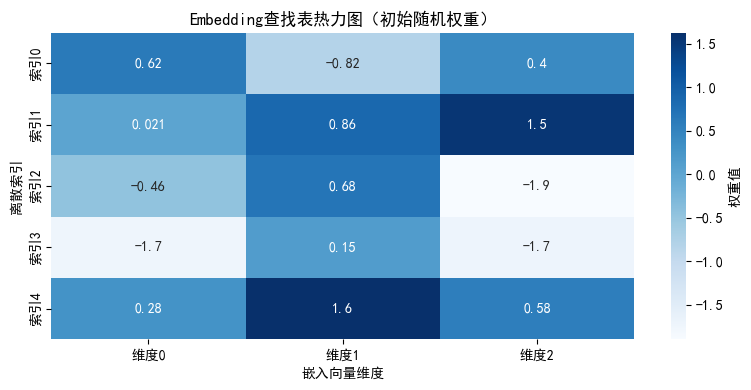

In [ ]:
plt.figure(figsize=(8, 4))
ax1 = sns.heatmap(embedding_table.numpy(), annot=True, cmap="Blues", 
                  xticklabels=[f"维度{i}" for i in range(3)],
                  yticklabels=[f"索引{i}" for i in range(5)])

ax1.collections[0].colorbar.set_label("权重值")
plt.title("Embedding查找表热力图（初始随机权重）", fontsize=12)
plt.xlabel("嵌入向量维度", fontsize=10)
plt.ylabel("离散索引", fontsize=10)
plt.tight_layout()
plt.show()

可视化结果解读：  

- 横轴：嵌入向量的维度（0-2），纵轴：离散数据的索引（0-4）；
- 每个单元格的数值：查找表的权重值，即对应索引 + 维度的嵌入向量值；
- 训练过程中，这些数值会通过反向传播不断更新，最终让语义相似的索引对应行的数值分布更接近。

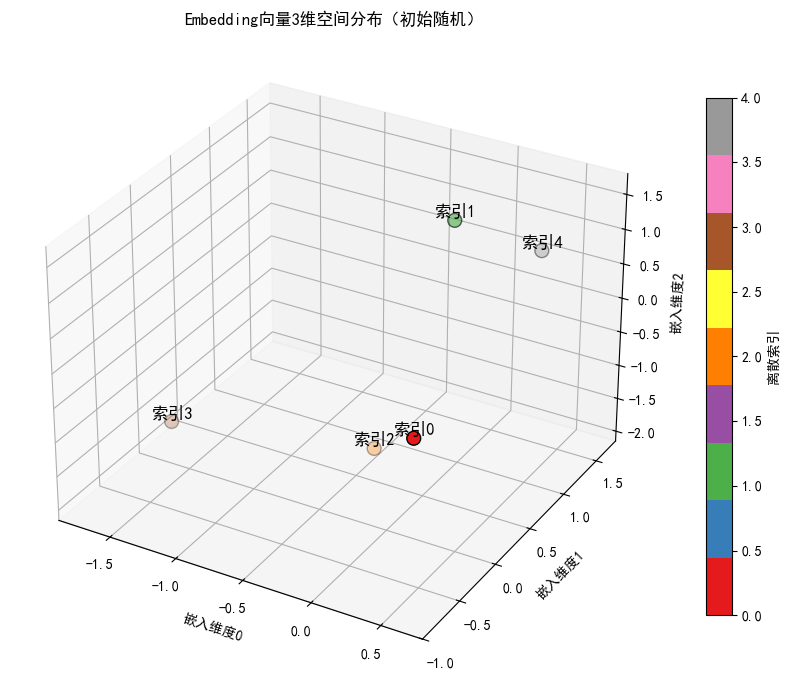

In [18]:
# 3维嵌入向量空间散点图可视化
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 提取每个索引的嵌入向量
x = embedding_table[:, 0].numpy()  # 维度0作为x轴
y = embedding_table[:, 1].numpy()  # 维度1作为y轴
z = embedding_table[:, 2].numpy()  # 维度2作为z轴

# 绘制散点图，每个索引对应一个点，标注索引编号
scatter = ax.scatter(x, y, z, s=100, c=range(5), cmap="Set1", edgecolors="black")
# 为每个点标注索引
for i in range(5):
    ax.text(x[i], y[i], z[i], f"索引{i}", fontsize=12, ha="center", va="bottom")

# 设置坐标轴和标题
ax.set_xlabel("嵌入维度0", fontsize=10)
ax.set_ylabel("嵌入维度1", fontsize=10)
ax.set_zlabel("嵌入维度2", fontsize=10)
ax.set_title("Embedding向量3维空间分布（初始随机）", fontsize=12)
# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label("离散索引", fontsize=10)

plt.tight_layout()
plt.show()

可视化结果解读：
- 每个彩色点代表一个离散索引的 3 维嵌入向量，点的位置由向量的 3 个维度值决定；
- 初始状态下，点的分布是随机的（因权重随机初始化），训练后，语义 / 特征相似的索引（如 NLP 中的 “苹果” 和 “香蕉”）对应的点会在空间中相互靠近，无关索引的点会远离；
- 这一特性是 Embedding 的核心价值 —— 让离散数据的向量表示具备语义关联性。

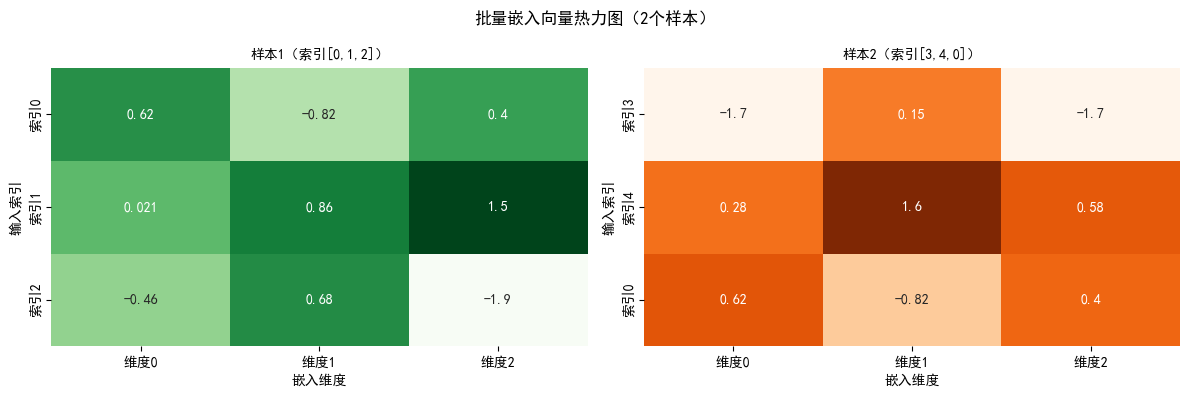

In [19]:
# 批量嵌入向量维度热力图（2样本×3索引，各3维向量）
batch_emb_np = batch_emb.detach().numpy()  # 分离计算图，转为numpy

# 绘制2个子图，分别对应2个样本
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("批量嵌入向量热力图（2个样本）", fontsize=12)

# 样本1：索引[0,1,2]的嵌入向量（3索引×3维度）
sns.heatmap(batch_emb_np[0], annot=True, cmap="Greens", ax=ax1,
            xticklabels=[f"维度{i}" for i in range(3)],
            yticklabels=[f"索引{i}" for i in [0,1,2]],
            cbar=False)
ax1.set_title("样本1（索引[0,1,2]）", fontsize=10)
ax1.set_xlabel("嵌入维度")
ax1.set_ylabel("输入索引")

# 样本2：索引[3,4,0]的嵌入向量（3索引×3维度）
sns.heatmap(batch_emb_np[1], annot=True, cmap="Oranges", ax=ax2,
            xticklabels=[f"维度{i}" for i in range(3)],
            yticklabels=[f"索引{i}" for i in [3,4,0]],
            cbar=False)
ax2.set_title("样本2（索引[3,4,0]）", fontsize=10)
ax2.set_xlabel("嵌入维度")
ax2.set_ylabel("输入索引")

plt.tight_layout()
plt.show()

可视化结果解读：
- 两个子图分别对应批量中的 2 个样本，每个子图是3 个输入索引 ×3 个嵌入维度的权重矩阵；
- 可清晰看到：样本 2 中索引 0 的嵌入向量，与样本 1 中索引 0 的嵌入向量完全一致（因为查表的行固定），验证了 “同一索引始终映射为同一嵌入向量” 的特性；
- 该可视化直接体现了批量查表的工作流程 —— 对批量中的每个索引，独立查找查找表并拼接结果。